# Popular Songs on Spotify

## The goal of this analysis is to attempt to boil down what makes a popular song truly popular.

## Although, I will not be using the "popularity" column as a target variable in this analysis. Instead, I will try to use PCA and k-Means clustering to find clusters of songs that are similar and use that to see if we can find significant differences in popularity between those groups.

## Using that, we will see if we can recommend some ideas for song writers and artists to make songs that are more likely, from a data standpoint, to become a hit!

### In the first notebook, I left the data alone and tried a simple Multiple Linear Regression. That didn't work out so well (R2 = 12.9%), so we are going to move on and try other methods. The first idea I had was to used unsupervised learning to cluster popular songs together.

### Then, when new data is entered in, throw it in and try to predict the popularity of the song based on the cluster it's in.

In [827]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [828]:
df = pd.read_csv('top10s.csv', encoding='iso-8859-1').drop(['Unnamed: 0'],axis=1)

In [829]:
df.head()

,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


In [830]:
# Select numeric for pca
df_numeric = df.select_dtypes('number')
df_numeric.tail()

,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
598,2019,104,66,61,-7,20,16,176,1,3,75
599,2019,95,79,75,-6,7,61,206,21,12,75
600,2019,136,76,53,-5,9,65,260,7,34,70
601,2019,114,79,60,-6,42,24,217,1,7,69
602,2019,150,44,70,-9,13,23,213,6,6,67


In [831]:
# Next, we want to standardize our data
def data_trans(data, transformation='center'):
    transformation = transformation.lower()
    
    if transformation == 'standardize':
        obj = preprocessing.StandardScaler(with_mean=True, with_std=True)
        trans_data = obj.fit_transform(data)
        
    elif transformation == 'center':
        obj = preprocessing.StandardScaler(with_mean=True, with_std=False)
        trans_data = obj.fit_transform(data)
        
    elif transformation == 'min/max':
        obj = preprocessing.MinMaxScaler()
        trans_data = obj.fit_transform(data)
    
    return pd.DataFrame(trans_data, columns=[data.columns])

In [832]:
# Standardize data
df_std = data_trans(df_numeric)

In [833]:
## Thanks to my friend Andrew (https://www.linkedin.com/in/andrew-francis-474366a8/) for being the brains behind this function!


def pca_plot(prin_comps):
    fig = plt.figure(figsize = (8,8))
    
    ax = fig.add_subplot(1, 1, 1)
    
    ax.scatter(prin_comps[0], prin_comps[1])
    
    ax.set_xlabel('Principal Component 1', fontsize=15)
    
    ax.set_ylabel('Principle Component 2', fontsize=15)
    
    ax.set_title('2 Component PCA', fontsize=20)
    
    return ax

In [834]:
## Thanks to my friend Andrew (https://www.linkedin.com/in/andrew-francis-474366a8/) for being the brains behind this function!


def color_pca_plot(color_by, prin_comps):
    prin_comps_id = pd.concat([color_by, prin_comps], axis=1)
    
    color_col = prin_comps_id.columns[0]
    
    cats = color_by.unique()
    
    colors = ['b', 'r', 'g', 'k', 'c', 'm', 'y']
    
    plt_colors = colors[0:len(cats)]
    
    fig = plt.figure(figsize = (8,8))
    
    ax = fig.add_subplot(1, 1, 1)
    
    for cat, color in zip(cats, plt_colors):
        
        indicesToKeep = prin_comps_id[color_col] == cat
        
        ax.scatter(prin_comps_id.loc[indicesToKeep, 0],
                  prin_comps_id.loc[indicesToKeep, 1],
                  c = color,
                  s = 50)
    ax.set_xlabel('Principal Component 1', fontsize=15)
    
    ax.set_ylabel('Principle Component 2', fontsize = 15)
    
    ax.set_title('2 component PCA', fontsize=20)
    
    ax.legend(cats)
    
    return ax

In [835]:
## Thanks to my friend Andrew (https://www.linkedin.com/in/andrew-francis-474366a8/) for being a big help with this function!

def PCA_Tools(data, n_vars = None, n_comp = 2, transformation = 'center',
             plot_scree = 'Yes',
             prin_plot = 'Yes',
             color_by = None,
             x_range = None,
             y_range = None,
             label_prin = None):
    
    # Do we want to use all the columns for the data?
    if n_vars != None:
        data = data[data.columns[0:n_vars]]
    
    # Use our data_trans function from above
    if transformation != None:
        data = data_trans(data, transformation)
    
    # Conduct the PCA
    pca_obj = PCA(n_components=n_comp)
    
    # Fit the new pca object to our data
    pca_obj.fit(data)
    
    # Create Labels for scree plot
    pc_labels = []
    
    # Label the principle components
    for i in range(1, n_comp+1):
        pc_labels.append('PC'+str(i))
    
    # Scree plot
    if plot_scree.lower() == 'yes':
        EVR = pca_obj.explained_variance_ratio_ * 100
        plt.bar(pc_labels, EVR)
        plt.title('Scree Plot')
        plt.ylabel('Percentage of Explained Variance')
        plt.show()
    
    # Save the principle components to a dataframe
    prin_comps = pd.DataFrame(pca_obj.fit_transform(data))
    
    ## Plot the data in 2-feature space
    if prin_plot.lower() == 'yes':
        # Do we need to color the PCA plot by something?
        # If so, use our colored PCA plot function
        # If not, use the pca_plot function
        if type(color_by) != type(None):
            ax = color_pca_plot(color_by, prin_comps)
        else:
            ax = pca_plot(prin_comps)
        
        ## Will label all the point on the PCA Plot with their index value
        if label_prin != None:
            subset_labels = prin_comps[abs(prin_comps[1]) > (abs(prin_comps[1].median() * 3))]
        
            for i in subset_labels.index.values:
                ax.annotate(i , (prin_comps.iloc[i][0], prin_comps.iloc[i][1]))
            
        if x_range != None:
            ax.set_xlim(x_range[0], x_range[1])
        
        if y_range != None:
            ax.set_ylim(y_range[0], y_range[1])
    
    return prin_comps

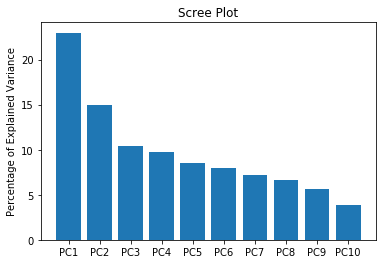

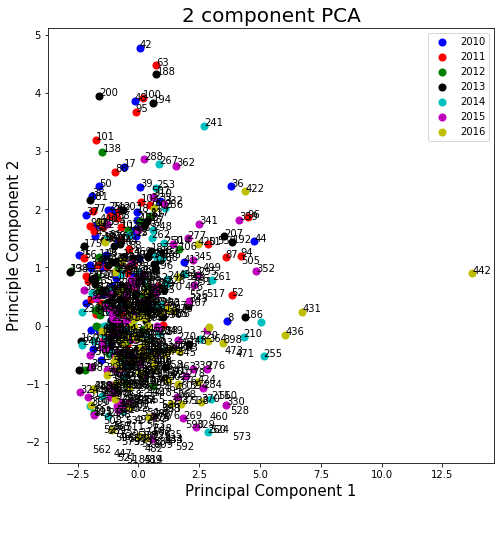

In [836]:
pca_obj = PCA_Tools(
                
                ## Set the dataset to perform PCA on
                data = df_numeric,

                ## Sets the nunmber of columns to use from the dataset
                ## This should usually be equal to None
                n_vars = None,

                ## Set number of components to return
                n_comp = 10,

                ## Choose the scaling technique
                # center, standardize, min/max
                transformation = 'standardize',

                plot_scree = 'Yes',

                prin_plot = 'Yes',

                ## Choose the categorical var to color the data by
                color_by = df_numeric['year'],

                ## Input the range of values that the y-axis will display
                ## If none, it will autofit
                y_range = None,

                label_prin = 'Yes')

In [837]:
# Big Outlier
#pca_obj.iloc[442,]
#df.iloc[442,]
#df = df.drop(442)
#df_numeric = df_numeric.drop(442)

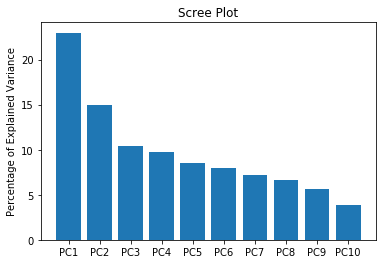

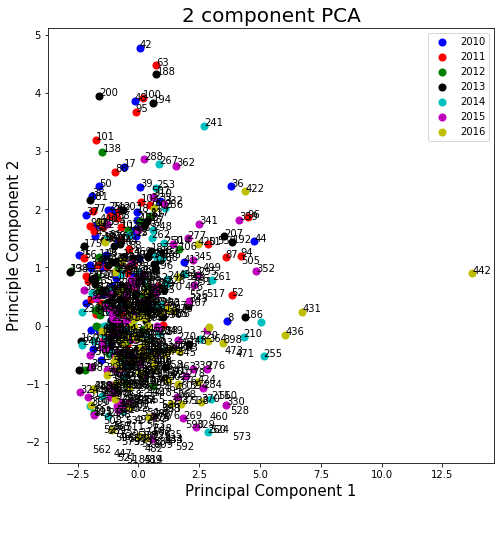

In [838]:
pca_obj = PCA_Tools(data = df_numeric, n_vars = None, n_comp = 10, transformation = 'standardize', plot_scree = 'Yes',
                    prin_plot = 'Yes', color_by = df_numeric['year'], y_range = None, label_prin = 'Yes')

## PCA Function is able to color by a categorical variable. So, let's bin our popularities into 5 groups. Then do a k-means clustering to see if we can find clusters!

In [839]:
# To bin, we will use Quantile-based Discretization using qcut in pandas
df_numeric['bin_pop'] = pd.qcut(df_numeric['pop'], q=5)

/Users/samlafell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [840]:
bin_labels_5 = ['Not Popular', 'Slightly Popular', 'Popular', 'Above Average', 'Most Popular']
df_numeric['bin_pop_info'] = pd.qcut(df_numeric['pop'],
                              q=5,
                              labels=bin_labels_5)

/Users/samlafell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [841]:
df_numeric['pop_model'] = pd.qcut(df_numeric['pop'],
                              q=5,
                              labels=False)

In [842]:
df_numeric['pop_model'].value_counts()

2    127
0    127
3    126
1    123
4    100
Name: pop_model, dtype: int64

In [843]:
# Features and Target DF
X_numeric = df_numeric.iloc[:, 0:10]
y = df_numeric.iloc[:,10:]

In [844]:
def explore_kmclusters( data, cluster_try = 10, random_state = None, ):
    
    '''
    
    :param data: can only be numeric dataframe
    
    Will create an elblow plot showing the reduction in the sum of squared
    distances between cluster centroids and data points assigned to
    them as the number of clusters is increased
    
    '''
    
    sil_score_max = -1
    
    cluster_tries = [i for i in range(2, cluster_try+1)]
    
    ssd = []
    
    for n_clust in cluster_tries:
        
        km = KMeans(n_clusters = n_clust, random_state = random_state).fit(data)
        
        ssd.append(km.inertia_)
        
        labels = km.predict(data)
        
        sil_score = silhouette_score(data, labels)
        
        print('The Silhouette Score for', n_clust, 'clusters is', round(sil_score, 3))
        
        # Store the best silhouette score
        
        if sil_score > sil_score_max:
            
            sil_score_max = sil_score
            
            best_n_clusters = n_clust
            
    plt.axvline(best_n_clusters, linestyle='--', color='black')
        
    plt.legend(['Silhouette Score Recommended Clusters'])
        
    plt.plot(cluster_tries, ssd)
    
    plt.scatter(cluster_tries, ssd)
    
    plt.xlabel('Clusters')
    
    plt.ylabel('Sum of Squared Distances')

The Silhouette Score for 2 clusters is 0.281
The Silhouette Score for 3 clusters is 0.268
The Silhouette Score for 4 clusters is 0.234
The Silhouette Score for 5 clusters is 0.167
The Silhouette Score for 6 clusters is 0.157
The Silhouette Score for 7 clusters is 0.16
The Silhouette Score for 8 clusters is 0.15
The Silhouette Score for 9 clusters is 0.15
The Silhouette Score for 10 clusters is 0.149


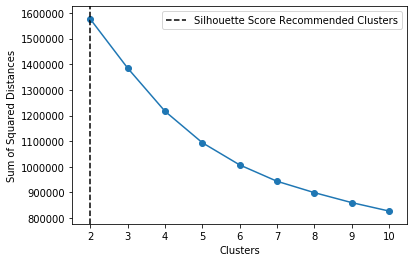

In [845]:
explore_kmclusters(X_numeric, cluster_try=10)

In [846]:
kmeans_clusters = KMeans(n_clusters = 6, random_state = 1234).fit(X_numeric)

In [847]:
kmeans_clusters.labels_

array([2, 3, 2, 3, 0, 0, 2, 5, 1, 4, 4, 5, 2, 4, 4, 3, 2, 3, 3, 2, 3, 5,
       4, 2, 4, 4, 2, 4, 4, 0, 4, 2, 2, 3, 4, 2, 1, 4, 4, 5, 2, 3, 5, 2,
       1, 2, 0, 4, 3, 2, 2, 3, 1, 4, 0, 0, 4, 2, 3, 0, 2, 4, 4, 3, 5, 0,
       3, 2, 5, 4, 0, 3, 3, 4, 0, 2, 3, 4, 4, 2, 4, 3, 4, 0, 2, 4, 3, 1,
       0, 2, 4, 4, 4, 0, 1, 3, 1, 2, 2, 2, 3, 4, 4, 1, 0, 4, 3, 4, 2, 0,
       2, 2, 0, 2, 4, 4, 2, 0, 2, 2, 4, 4, 3, 2, 4, 4, 4, 5, 4, 4, 4, 2,
       5, 0, 2, 2, 2, 4, 4, 5, 4, 0, 0, 2, 5, 0, 0, 4, 1, 5, 4, 5, 2, 4,
       3, 0, 2, 2, 0, 2, 2, 4, 3, 4, 5, 4, 4, 3, 0, 4, 0, 4, 3, 3, 2, 2,
       0, 0, 4, 4, 0, 5, 3, 3, 0, 2, 1, 3, 3, 0, 4, 2, 1, 0, 3, 4, 3, 4,
       2, 0, 5, 4, 4, 4, 4, 2, 4, 1, 2, 3, 1, 1, 4, 4, 4, 4, 0, 4, 2, 2,
       1, 2, 4, 0, 0, 4, 3, 4, 0, 5, 0, 2, 4, 5, 0, 2, 4, 2, 4, 4, 2, 3,
       4, 4, 0, 5, 0, 2, 5, 1, 3, 2, 5, 5, 4, 1, 3, 4, 2, 2, 1, 1, 5, 0,
       0, 0, 2, 3, 3, 1, 0, 1, 4, 1, 4, 0, 5, 5, 1, 2, 4, 2, 2, 0, 1, 0,
       5, 0, 5, 0, 4, 0, 2, 4, 4, 3, 2, 4, 0, 2, 5,

## Next, we want to put these things together. Both the PCA and the k-Means.

## We only have 10 informative columns as it is, so we want to cut that in half with PCA. Pull out 5 components. Then cluster using k-Means.

## Using this, we will append the popularity column back to the dataframe and see which of our clusters we can say are more popular than other clusters!

In [848]:
X_numeric.shape

(603, 10)

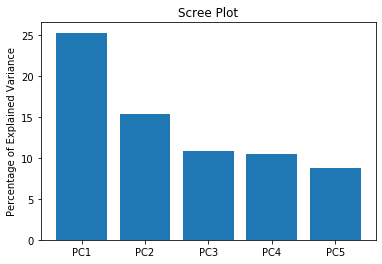

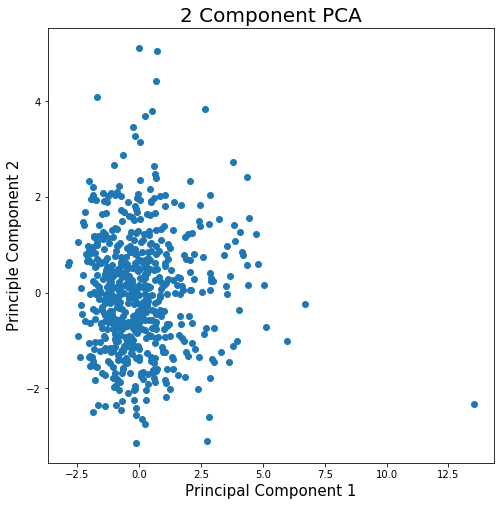

In [849]:
pca_obj = PCA_Tools(data = X_numeric, n_vars = None, n_comp = 5, transformation = 'standardize', plot_scree = 'Yes',
                    prin_plot = 'Yes', color_by = None, y_range = None, label_prin = None)

The Silhouette Score for 2 clusters is 0.356
The Silhouette Score for 3 clusters is 0.181
The Silhouette Score for 4 clusters is 0.193
The Silhouette Score for 5 clusters is 0.193
The Silhouette Score for 6 clusters is 0.183
The Silhouette Score for 7 clusters is 0.196
The Silhouette Score for 8 clusters is 0.189
The Silhouette Score for 9 clusters is 0.181
The Silhouette Score for 10 clusters is 0.182


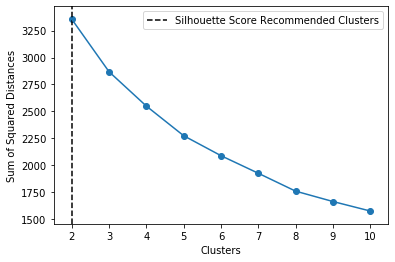

In [850]:
explore_kmclusters(pca_obj, cluster_try=10)

Silhouette score recommended 2 clusters, but we are going to go with 6. Using this plot, it looks like information gain slows down around that point. This chart is difficult becuase there is no real "elbow" so we are going to go with a best guess.

In [851]:
kmeans_clusters = KMeans(n_clusters = 6, random_state = 1234).fit(pca_obj)
cluster_df = pd.DataFrame(kmeans_clusters.labels_, columns=['kmeans_cluster'])
pop_cluster_df = pd.DataFrame(y['pop_model']).join(cluster_df)
pop_cluster_df = pop_cluster_df.dropna()

In [852]:
model_df = X_numeric.join(pop_cluster_df).dropna()

In [853]:
# Some descriptive statistics of our kmeans clusters
model_df.groupby('kmeans_cluster').agg(['median', 'mean'])

year                 bpm               nrgy             \
               median         mean median        mean median       mean   
kmeans_cluster                                                            
0                2017  2016.515152    115  113.500000   74.5  73.712121   
1                2015  2014.744681    116  112.382979   37.0  35.872340   
2                2015  2014.765625    160  157.812500   76.0  72.453125   
3                2015  2014.489796    105  113.102041   73.0  71.959184   
4                2012  2011.963855    126  121.885542   82.0  81.180723   
5                2016  2015.758621    104  105.820690   67.0  65.234483   

                 dnce                dB            ...    val             \
               median       mean median      mean  ... median       mean   
kmeans_cluster                                     ...                     
0                  75  75.227273   -5.0 -5.053030  ...   66.5  67.780303   
1                  48  47.361702   -7.0 -8.744681  ...   23.0  24.638298   
2                  50  47.843750   -5.5 -5.593750  ...   33.0  36.937500   
3                  65  64.204082   -6.0 -5.857143  ...   64.0  62.306122   
4                  68  67.518072   -4.0 -4.506024  ...   64.5  63.524096   
5                  63  63.786207   -6.0 -6.158621  ...   37.0  37.413793   

                  dur              acous              spch             \
               median        mean median       mean median       mean   
kmeans_cluster                                                          
0                 202  201.863636      5   9.765152      6   7.174242   
1                 236  240.170213     73  65.446809      3   3.510638   
2                 216  220.921875      4   7.281250      7   9.156250   
3                 227  241.591837      9  19.448980     25  27.183673   
4                 225  229.000000      2   6.385542      5   6.734940   
5                 228  231.406897      6  12.379310      5   6.151724   

               pop_model            
                  median      mean  
kmeans_cluster                      
0                    2.0  2.272727  
1                    1.0  1.702128  
2                    2.0  1.984375  
3                    2.0  1.653061  
4                    1.5  1.650602  
5                    2.0  2.020690  

[6 rows x 22 columns]

## For our numeric columns, let's do a test of means across all levels of k-means clusters!

In [543]:
model_df.columns[1:10][1]

sig_list = [[]]*len(range(0,100))

for i in range(2,10):
    # Define the Column we are looking at
    column = model_df.columns[i]
    
    # Define the combinations for the indices
    comb = combinations(model_df['kmeans_cluster'].unique(),2)
    
    # What alpha are you using
    alpha = 0.01
    
    # Look across all the possible k-means groups using the indicies
    for k in list(comb):
        # Record the groups we are looking at
        groups = [k[0], k[1]]
        # Conduct the t-test assuming uneqaul variances (Welch's T-Test)
        p_val = stats.ttest_ind(model_df[column][model_df['kmeans_cluster'] == k[0]], model_df[column][model_df['kmeans_cluster'] == k[1]], equal_var=False)[1]
        # If the p-value is smaller than the alpha, append info to a list
        if p_val < alpha:
            sig_list[i].append([column, groups, p_val])
                    

In [551]:
sig_differences = pd.DataFrame(pd.DataFrame(sig_list[1]))

In [554]:
sig_differences.columns = ['Original_col', 'kmeans_clusters', 'p_val']

## Sort from largest to smallest p-value... I.e., most significantly different to least significantly different

In [564]:
sig_differences.sort_values(['p_val'])

,Original_col,kmeans_clusters,p_val
40,val,"[2.0, 0.0]",3.712757e-24
3,nrgy,"[2.0, 0.0]",2.830436e-22
24,dB,"[2.0, 0.0]",6.346372e-21
2,nrgy,"[2.0, 1.0]",3.710044e-20
5,nrgy,"[3.0, 1.0]",2.189543e-17
...,...,...,...
35,live,"[4.0, 1.0]",3.915206e-03
41,val,"[2.0, 5.0]",4.865486e-03
9,nrgy,"[4.0, 0.0]",5.567554e-03
69,spch,"[4.0, 0.0]",6.785159e-03


## How many times are the various clusters different?

In [583]:
sig_differences.kmeans_clusters.value_counts()

[3.0, 1.0]    7
[1.0, 5.0]    6
[2.0, 5.0]    6
[2.0, 3.0]    6
[2.0, 1.0]    5
[2.0, 4.0]    5
[3.0, 0.0]    5
[4.0, 1.0]    5
[3.0, 5.0]    4
[2.0, 0.0]    4
[3.0, 4.0]    4
[1.0, 0.0]    4
[0.0, 5.0]    4
[4.0, 5.0]    3
[4.0, 0.0]    3
Name: kmeans_clusters, dtype: int64

## Out of how many times were these clusters significant that they *could* have been significant?

### i.e., Clusters [3.0, 1.0] were different 7 times when they could've been different 12.

In [582]:
sig_differences.kmeans_clusters.value_counts() / model_df.shape[1]

[3.0, 1.0]    0.583333
[1.0, 5.0]    0.500000
[2.0, 5.0]    0.500000
[2.0, 3.0]    0.500000
[2.0, 1.0]    0.416667
[2.0, 4.0]    0.416667
[3.0, 0.0]    0.416667
[4.0, 1.0]    0.416667
[3.0, 5.0]    0.333333
[2.0, 0.0]    0.333333
[3.0, 4.0]    0.333333
[1.0, 0.0]    0.333333
[0.0, 5.0]    0.333333
[4.0, 5.0]    0.250000
[4.0, 0.0]    0.250000
Name: kmeans_clusters, dtype: float64

### Clusters 4 and 2 (3,1 with 0 index) are significantly different the most. Check out their mean values and find where they are most different

In [594]:
model_df[model_df['kmeans_cluster'] == 3.0].mean() -  model_df[model_df['kmeans_cluster'] == 1.0].mean()

year              -1.651484
bpm                0.439609
nrgy              32.869096
dnce              16.162955
dB                 2.226046
live              25.020580
val               21.859987
dur                9.364372
acous            -45.470985
spch               8.396424
pop_model         -0.116734
kmeans_cluster     2.000000
dtype: float64

This cluster is not incredibly different in terms of popularity, but has some other attributes that are interesting. Cluster 4 has considerably more energy. But the Live rating is 25 points higher, which means it seems like songs that were performed Live tended to get lumped into the 3rd cluster.

### Clusters 3 and 1 (2,0 with 0 index) have really large p-values in their differences. Check out their mean values and find where they are most different

In [595]:
model_df[model_df['kmeans_cluster'] == 2.0].mean() -  model_df[model_df['kmeans_cluster'] == 0.0].mean()

year              -3.628515
bpm               10.999376
nrgy              13.343555
dnce               1.477061
dB                 1.489106
live              -0.561714
val               22.906517
dur               -0.584797
acous             -7.391352
spch              -0.607160
pop_model         -0.441789
kmeans_cluster     2.000000
dtype: float64

Val = Valence. The higher the value, the more positive mood for the song.

Cluster 3 looks like higher energy, and songs that were generally determined to be "happier".

Less popular though, looking at pop_model

## Let's measure proportion differences on popularity!

In [609]:
# How to get the cross tab table
table = pd.crosstab(index=model_df['kmeans_cluster'], columns=model_df['pop_model'])

We need to do a Pearson Chi-Square test for the Ordinal-Nominal test of association! Thanks Dr. LaBarr for helping me out on this one.

and thank you.. https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

In [612]:
# Find the Test Stat, Degrees of Freedom, Expected Values from the chi2_contingency function from scipy
stat, p, dof, expected = chi2_contingency(table)
# Degrees of Freedom
print('dof=%d' % dof)
# Expected Values
print(expected)

dof=20
[[31.65723794 30.90349418 31.65723794 31.65723794 25.12479201]
 [10.90183028 10.6422629  10.90183028 10.90183028  8.65224626]
 [28.93178037 28.24292845 28.93178037 28.93178037 22.96173045]
 [11.95008319 11.6655574  11.95008319 11.95008319  9.48419301]
 [13.41763727 13.09816972 13.41763727 13.41763727 10.64891847]
 [29.14143095 28.44758735 29.14143095 29.14143095 23.1281198 ]]


In [614]:
# What Alpha are we using?
prob = 0.95
# Find the critical value according to the alpha and the degrees of freedom
critical = chi2.ppf(prob, dof)
# What are our parameters?
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
# Should we reject or fail to reject our null?
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

probability=0.950, critical=31.410, stat=39.113
Dependent (reject H0)


## So, we have a relationship between k-Means Cluster and Popularity Quantile Bin. Although, we don't know where that relationship is occuring at. We need to dive deeper and compare 2x2 tables.

In [823]:
# Where are the significant differences occuring between our kmeans clusters?
comb = list(combinations([0,1,2,3,4],2))
sig_diff = []
alpha = .03
for i in range(0,4):
    stat, p, dof, expected = chi2_contingency(table[[comb[i][0],comb[i][1]]])
    if p < alpha:
        sig_diff.append([comb[i][0],comb[i][1], p])

sig_diff

[[0, 2, 0.013413927170097302], [0, 4, 0.028373965868719868]]

## Interpretation of the results:

At an alpha of .03, we find our kmeans clusters are significantly different in terms of song popularity between Popularity Bins 1 & 3, and then again between Popularity Bins 1 & 5.

This tells us that our kmeans clusters are significantly different at a popularity of 1 & 3 and then significantly different at a popularity of 1 & 5.

-- A few things to note, these alphas are not incredibly low, so finding a difference is dependant on the alpha that we are using and not incredibly significant.

-- We were able to find VERY siginificant differences between attributes of these songs across clusters, but not necessarily significant differences in popularity. That could lend itself to the diversity of the data in the original dataset. Also, we have to rememeber that these songs were actaully pulled from songs that were already considered popular. Therefore, they should all really be popular.

-- I am going to move on to other analyses with this dataset using other methods. But this was a good attempt at using PCA/k-Means/Statistical Testing... to find differences in songs.

## Recommendations on how to Make a Popular Song from this unsupervised analysis and this dataset

The correlations aren't incredibly strong, but if we did learn anything, we can look at the differences for the least popular & most popular songs...

In [826]:
model_df[model_df['pop_model'] == 4.0].mean() -  model_df[model_df['pop_model'] == 0.0].mean()

year               2.085397
bpm                2.309365
nrgy              -6.626984
dnce               4.035079
dB                -0.029206
live              -2.620159
val                2.776190
dur              -10.044762
acous              5.177143
spch              -0.527778
pop_model          4.000000
kmeans_cluster     0.227460
dtype: float64

The overall difference between all 6 k-Means clusters had a p-value of .02837 for the Most Popular & Least Popular category. This means, there are some significant difference of popularity across the clusters.

Instead of making things more complicated than really necessary, let's look at some traits of the most popular songs and how they differ from the least popular. 

*This part does __NOT__ utilize the clusters, it is more of a common sense interpretation*

1) Energy in the more popular songs is actaully lower! So, more calm songs are generally being rated as more popular.

2) Although, danceability is, on average, 4 points higher.

3) The most striking result is the duration. The more popular songs, are on average, 10 seconds shorter than the least popular songs. This makes sense given I have the attention span of a 6 year old and I usually skip if I get bored.

Combining what we see above...
"Less energetic", "easier" to dance to, shorter, and songs with acoustic elements are falling into the higher popularity category

## Things to Watch for...

Analytics might not be an "exact" science especially with this dataset. The results could change based on amount of k-means clusters, how you bin the popular songs, and maybe instead of using PCA you can just cluster using the original columns (although standardized).

Changing any or all of these parameters would impact our results. Feel free to play around.

## Thoughts/Questions/Comments?

Reach out!
salafell@ncsu.edu

## Extra Code

In [184]:
## Define 2 random distributions
#Sample Size
N = 10
#Gaussian distributed data with mean = 2 and var = 1
a = np.random.randn(N) + 2
#Gaussian distributed data with with mean = 0 and var = 1
b = np.random.randn(N)


## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = a.var(ddof=1)
var_b = b.var(ddof=1)

#std deviation
s = np.sqrt((var_a + var_b)/2)
s



## Calculate the t-statistics
t = (a.mean() - b.mean())/(s*np.sqrt(2/N))



## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


print("t = " + str(t))
print("p = " + str(2*p))
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.


## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(a,b)
print("t = " + str(t2))
print("p = " + str(p2))

t = 7.624815427888269
p = 4.823811963206026e-07
t = 7.624815427888269
p = 4.823811963160319e-07


In [220]:
model_df.groupby('kmeans_cluster').bpm.mean()[1]

115.78846153846153

In [225]:
m1 = model_df[model_df['kmeans_cluster'] == 0].bpm.mean()
n1 = len(model_df[model_df['kmeans_cluster'] == 0])

In [228]:
m2 = model_df[model_df['kmeans_cluster'] == 1].bpm.mean()
n2 = len(model_df[model_df['kmeans_cluster'] == 1])

In [237]:
stats.ttest_ind(## First group
                model_df[model_df['kmeans_cluster'] == 0].bpm,
                ## Second group
                model_df[model_df['kmeans_cluster'] == 1].bpm,
                ## Don't assume equal variance
                equal_var=False)

Ttest_indResult(statistic=-1.2491054687669536, pvalue=0.2161308694762845)

In [243]:
bpm_pval = []

for i in range(0,5):
    groups = [i, i+1]
    p_val = stats.ttest_ind(## First group
                model_df[model_df['kmeans_cluster'] == i].bpm,
                ## Second group
                model_df[model_df['kmeans_cluster'] == i+1].bpm,
                ## Don't assume equal variance
                equal_var=False)[1]
    bpm_pval.append([groups, p_val])

print(bpm_pval)

[[[0, 1], 0.2161308694762845], [[1, 2], 0.2588176164424811], [[2, 3], 0.13668524991498915], [[3, 4], 1.903443274827828e-08], [[4, 5], 4.08928437732819e-10]]


In [263]:
sig_bpm_pval = []
comb = combinations(model_df['kmeans_cluster'].unique(),2)
alpha = 0.01
for i in list(comb):
    groups = [i[0], i[1]]
    p_val = stats.ttest_ind(## First group
                model_df[model_df['kmeans_cluster'] == i[0]].bpm,
                ## Second group
                model_df[model_df['kmeans_cluster'] == i[1]].bpm,
                ## Don't assume equal variance
                equal_var=False)[1]
    if p_val < alpha:
        sig_bpm_pval.append([groups, p_val])

pd.DataFrame(sig_bpm_pval, columns=['kmeans_clusters', 'p_val'])

[[[2.0, 4.0], 7.602088924577599e-08], [[2.0, 0.0], 1.899809648976083e-07], [[3.0, 4.0], 1.903443274827828e-08], [[4.0, 1.0], 1.2836861241067445e-06], [[4.0, 0.0], 1.181632814756633e-12], [[4.0, 5.0], 4.08928437732819e-10]]
